In [1]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, CIFAR10
using Plots              
using StatsBase

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\oliwi\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [2]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

"true"

In [3]:
train_set = CIFAR10(:train)

dataset CIFAR10:
  metadata  =>    Dict{String, Any} with 2 entries
  split     =>    :train
  features  =>    32×32×3×50000 Array{Float32, 4}
  targets   =>    50000-element Vector{Int64}

In [4]:
feats = Float32.(train_set.features)
labels= train_set.targets
channel_means = [ mean(vec(feats[:,:,c,:])) for c in 1:3 ]
channel_stds  = [ std( vec(feats[:,:,c,:]) ) for c in 1:3 ]
@info "Computed channel means: $channel_means"
@info "Computed channel stds:   $channel_stds"

┌ Info: Computed channel means: Float32[0.49139968, 0.48215845, 0.4465309]
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\DeepLearningProjektZaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:5
┌ Info: Computed channel stds:   Float32[0.24703224, 0.24348514, 0.26158786]
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\DeepLearningProjektZaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:6


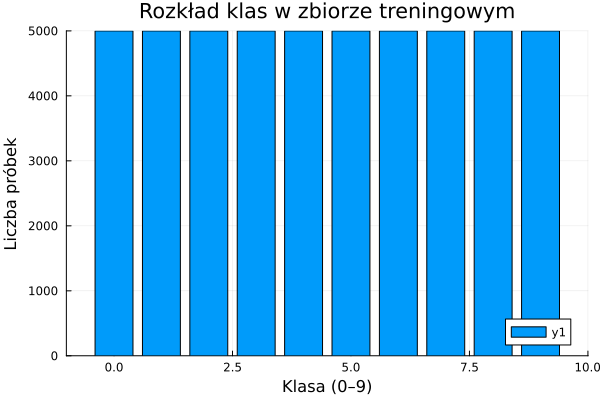

In [5]:
cls_counts = countmap(train_set.targets)
bar(
    0:9,
    [get(cls_counts, i, 0) for i in 0:9],
    xlabel="Klasa (0–9)",
    ylabel="Liczba próbek",
    title="Rozkład klas w zbiorze treningowym",
)

In [ ]:
using Images, ImageShow, Plots

classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]

# Funkcja do siatki 3×3
function show_samples_grid(X, Y; n=9)
    idx = rand(1:size(X,4), n)
    plt = plot(layout = (3,3), margin=2Plots.mm, xticks=false, yticks=false)
    for (i,j) in enumerate(idx)
        raw = X[:,:,:,j] |> cpu
        chw = permutedims(raw, (3,2,1))
        img = collect(colorview(RGB, chw))
        lab = isa(Y, AbstractMatrix) ? argmax(Y[:,j]) - 1 : Y[j]
        title = classes[lab+1]
        plot!(plt[i], img, seriestype = :heatmap,
              aspect_ratio=1, axis=false, title=title)
    end
    display(plt)
end


show_samples_grid (generic function with 1 method)

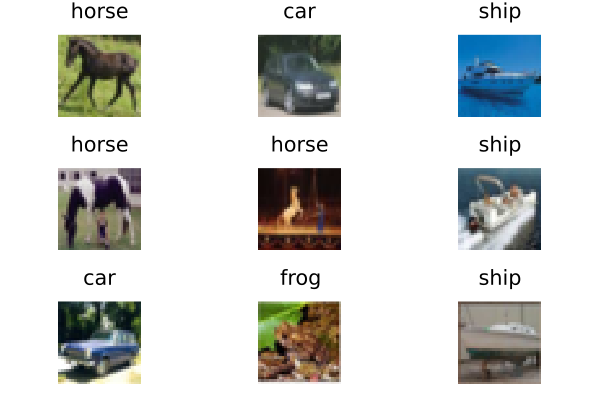

In [7]:
show_samples_grid(feats, train_set.targets; n=9)

In [6]:
use_cuda = true

true

In [7]:
if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on CPU
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\DeepLearningProjektZaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:6


In [ ]:
using Pkg
Pkg.add("ColorTypes")

   Resolving package versions...
    Updating `C:\Users\oliwi\.julia\environments\v1.11\Project.toml`
⌅ [3da002f7] + ColorTypes v0.11.5
  No Changes to `C:\Users\oliwi\.julia\environments\v1.11\Manifest.toml`


In [ ]:
using Augmentor: Pipeline, Rotate, CropSize, ShearX, ShearY, augment
using ColorTypes: RGB

pl = Rotate(-15:15)             |>
     CropSize(32, 32)           |>
     (ShearX(-10:10) * ShearY(-10:10)) |>
     CropSize(32, 32)

raw = feats[:,:,:,1]
img0 = colorview(RGB, permutedims(raw, (3,1,2)))  
img = Array(img0)                                 

augmented_list = augment(pl, [img])  
img_aug = augmented_list[1]           

using Plots
plot(layout=(1,2), axis=false)
plot!(1, img0,    title="Oryginał")
plot!(2, img_aug, title="Augmented")


MethodError: MethodError: no method matching _plain_augment(::Augmentor.ImmutablePipeline{4, Tuple{Rotate{UnitRange{Int64}}, CropSize{2}, Augmentor.Either{2, Tuple{ShearX{UnitRange{Int64}}, ShearY{UnitRange{Int64}}}}, CropSize{2}}}, ::Vector{Matrix{RGB{Float32}}})
The function `_plain_augment` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  _plain_augment(::Any, !Matched::Augmentor.Operation)
   @ Augmentor C:\Users\oliwi\.julia\packages\Augmentor\96doC\src\augment.jl:100
  _plain_augment(::Any, !Matched::Union{Tuple{Augmentor.Operation}, Augmentor.ImmutablePipeline{1}})
   @ Augmentor C:\Users\oliwi\.julia\packages\Augmentor\96doC\src\augment.jl:96
  _plain_augment(::Any, !Matched::Union{Pipeline, Tuple{Vararg{Augmentor.Operation}}})
   @ Augmentor C:\Users\oliwi\.julia\packages\Augmentor\96doC\src\augment.jl:92


In [ ]:
function make_minibatch_aug(X, Y, idxs)
  B = length(idxs)
  Xb = Array{Float32}(undef, 32,32,3,B)
  for (i, idx) in enumerate(idxs)
    raw = X[:,:,:,idx]             
    img = colorview(RGB, permutedims(raw,(3,1,2)))
    img2 = first(Augmentor.apply(pl, img))
    arr = Float32.(channelview(img2))   
    Xb[:,:,:,i] = permutedims(arr,(2,3,1))
  end
  Yb = Flux.onehotbatch(Y[idxs], 0:9)
  return Xb, Yb
end

In [ ]:
batch_size = 64
mb_idxs = partition(1:size(feats,4), batch_size)
use_cuda = CUDA.functional()
device = use_cuda ? gpu : cpu

train_set = [ make_minibatch_aug(feats, labels, idxs) |> device
              for idxs in mb_idxs ]


using Images, ImageShow

function show_augmented_grid(n=9)
  idxs = rand(1:length(mb_idxs), 1) |> first   
  Xb, Yb = make_minibatch_aug(feats, labels, mb_idxs[idxs])
  show_samples_grid(Xb, Yb; n=n)
end

show_augmented_grid(9)

In [10]:
epochs = 150;
batch_size = 64;

In [11]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, 32, 32, 3, length(idxs))
    for (i, idx) in enumerate(idxs)
        X_batch[:,:,:,i] = X[:,:,:,idx]
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return X_batch, Y_batch
end

make_minibatch (generic function with 1 method)

In [12]:
mb_idxs = partition(1:size(train_set.features, 4), batch_size)
train_set = [make_minibatch(train_set.features, train_set.targets, i)  |> device for i in mb_idxs]

782-element Vector{Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.23137255 0.0627451 … 0.7058824 0.69411767; 0.16862746 0.0 … 0.6784314 0.65882355; … ; 0.59607846 0.46666667 … 0.38039216 0.5921569; 0.5803922 0.47843137 … 0.3254902 0.48235294;;; 0.24313726 0.078431375 … 0.54509807 0.5647059; 0.18039216 0.0 … 0.48235294 0.5058824; … ; 0.49019608 0.3254902 … 0.24313726 0.4627451; 0.4862745 0.34117648 … 0.20784314 0.36078432;;; 0.24705882 0.078431375 … 0.3764706 0.45490196; 0.1764706 0.0 … 0.16470589 0.36862746; … ; 0.4 0.19607843 … 0.13333334 0.32941177; 0.40392157 0.22352941 … 0.13333334 0.28235295;;;; 0.6039216 0.54901963 … 0.64705884 0.6392157; 0.49411765 0.5686275 … 0.6117647 0.61960787; … ; 0.34117648 0.3019608 … 0.48235294 0.56078434; 0.30980393 0.2784314 … 0.5137255 0.56078434;;; 0.69411767 0.627451 … 0.6039216 0.5803922; 0.5372549 0.6 … 0.59607846 0.5803922; … ; 0.3529412 0.3137255 … 0.44705883 0.5254902; 0.31764707 0.28627452 … 0.4745098 0.5215

In [ ]:
# mb_idxs = partition(1:size(train_set.features, 4), batch_size)
# train_set = [make_minibatch(train_set.features, train_set.targets, i) for i in mb_idxs] |> device

782-element Vector{Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.23137255 0.0627451 … 0.7058824 0.69411767; 0.16862746 0.0 … 0.6784314 0.65882355; … ; 0.59607846 0.46666667 … 0.38039216 0.5921569; 0.5803922 0.47843137 … 0.3254902 0.48235294;;; 0.24313726 0.078431375 … 0.54509807 0.5647059; 0.18039216 0.0 … 0.48235294 0.5058824; … ; 0.49019608 0.3254902 … 0.24313726 0.4627451; 0.4862745 0.34117648 … 0.20784314 0.36078432;;; 0.24705882 0.078431375 … 0.3764706 0.45490196; 0.1764706 0.0 … 0.16470589 0.36862746; … ; 0.4 0.19607843 … 0.13333334 0.32941177; 0.40392157 0.22352941 … 0.13333334 0.28235295;;;; 0.6039216 0.54901963 … 0.64705884 0.6392157; 0.49411765 0.5686275 … 0.6117647 0.61960787; … ; 0.34117648 0.3019608 … 0.48235294 0.56078434; 0.30980393 0.2784314 … 0.5137255 0.56078434;;; 0.69411767 0.627451 … 0.6039216 0.5803922; 0.5372549 0.6 … 0.59607846 0.5803922; … ; 0.3529412 0.3137255 … 0.44705883 0.5254902; 0.31764707 0.28627452 … 0.4745098 0.5215

In [20]:
test_set = CIFAR10(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[4]) |> device

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [ ]:
# test_set   = CIFAR10(:test)
# test_feats  = Float32.(test_set.features)
# test_labels = test_set.targets

# test_idxs = partition(1:size(test_feats,4), batch_size)

# test_set = [ make_minibatch(test_feats, test_labels, idxs) |> device for idxs in test_idxs ]


157-element Vector{Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.

In [29]:
model = Chain(
    Conv((5,5), 3=>16, relu),
    MaxPool((2,2)),
    Conv((5,5), 16=>8, relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(200, 120),
    Dense(120, 84),
    Dense(84, 10),
    softmax
) |> device

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#29#30"(),
  Dense(200 => 120),                    # 24_120 parameters
  Dense(120 => 84),                     # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 155.328 KiB.

In [30]:
model(train_set[1][1])

10×64 Matrix{Float32}:
 0.0941633  0.100524   0.117416   …  0.101236   0.0965508  0.100213
 0.0884494  0.0976842  0.0819656     0.0986104  0.10304    0.0910193
 0.0935055  0.0775246  0.098251      0.0856807  0.0871512  0.0928846
 0.143361   0.148603   0.127787      0.121174   0.117307   0.131587
 0.10286    0.106394   0.0995309     0.103908   0.0994873  0.0986669
 0.0794204  0.0704407  0.0819696  …  0.0740895  0.077868   0.0806973
 0.0964003  0.0896847  0.0923346     0.103527   0.105689   0.0984466
 0.105186   0.105492   0.0992483     0.108923   0.115961   0.102947
 0.077895   0.0770605  0.0760682     0.0804349  0.0916305  0.086358
 0.11876    0.126592   0.125428      0.122416   0.105315   0.11718

In [14]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end

loss (generic function with 2 methods)

In [32]:
loss(model, test_set[1],test_set[2])

2.3178692f0

In [15]:
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [34]:
accuracy(model,test_set[1],test_set[2])

0.1022

In [17]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

UndefVarError: UndefVarError: `model` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model, train_set, opt_state)
    acc = accuracy(model,test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to small_model_1.bson")
        ps = cpu(Flux.state(model))
        BSON.@save "small_model_1.bson" ps
        jldsave("small_model_1.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X32sZmlsZQ==.jl:1
┌ Info: [1]: Test accuracy: 0.4422
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X32sZmlsZQ==.jl:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X32sZmlsZQ==.jl:10
┌ Info: [2]: Test accuracy: 0.4706
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X32sZmlsZQ==.jl:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa9

In [16]:
model = Chain(
    Conv((5,5), 3=>16, relu),
    MaxPool((2,2)),
    Conv((5,5), 16=>8, relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(200, 120),
    Dense(120, 84),
    Dense(84, 10),
    softmax
) |> device

BSON.@load "small_model_1.bson" ps

Flux.loadmodel!(model, device(ps))

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#22#23"(),
  Dense(200 => 120),                    # 24_120 parameters
  Dense(120 => 84),                     # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 155.328 KiB.

In [21]:
accuracy(model,test_set[1],test_set[2])

0.5857

In [ ]:
X_test, Y_test = test_set   

preds = Flux.onecold(model(X_test), 0:9)
trues = Flux.onecold(Y_test,      0:9)

class_correct = zeros(Int, 10)
class_total   = zeros(Int, 10)

for (p, t) in zip(preds, trues)
    class_total[t+1]   += 1       
    class_correct[t+1] += (p == t)
end

class_accuracy = class_correct ./ class_total
for i in 1:10
    @printf("%-6s: %5.2f%%  (%4d/%4d)\n",
        classes[i], 100*class_accuracy[i],
        class_correct[i], class_total[i])
end


plane : 56.90%  ( 569/1000)
car   : 69.90%  ( 699/1000)
bird  : 42.30%  ( 423/1000)
cat   : 39.80%  ( 398/1000)
deer  : 51.70%  ( 517/1000)
dog   : 53.80%  ( 538/1000)
frog  : 59.90%  ( 599/1000)
horse : 69.20%  ( 692/1000)
ship  : 77.70%  ( 777/1000)
truck : 64.50%  ( 645/1000)


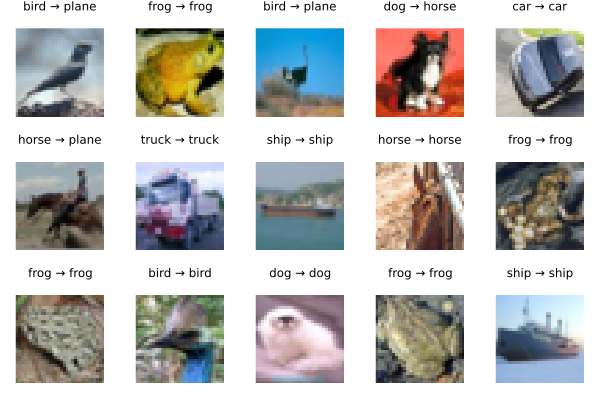

In [29]:
using Images, ImageShow, Plots

preds = Flux.onecold(model(X_test), 0:9)
trues = Flux.onecold(Y_test,      0:9)

function show_predictions(X, trues, preds; n=10)
    idxs = rand(1:size(X,4), n)
    cols = min(n,5); rows = ceil(Int,n/cols)
    plt = plot(layout=(rows,cols), margin=2Plots.mm, xticks=false, yticks=false)
    for (i,j) in enumerate(idxs)
        raw = X[:,:,:,j] |> cpu
        chw = permutedims(raw, (3,2,1))
        img = collect(colorview(RGB, chw))
        title = "$(classes[trues[j]+1]) → $(classes[preds[j]+1])"
        plot!(plt[i], img, seriestype=:heatmap,
              aspect_ratio=1, axis=false, title=title, titlefontsize=8)
    end
    display(plt)
end

show_predictions(X_test, trues, preds; n=15)


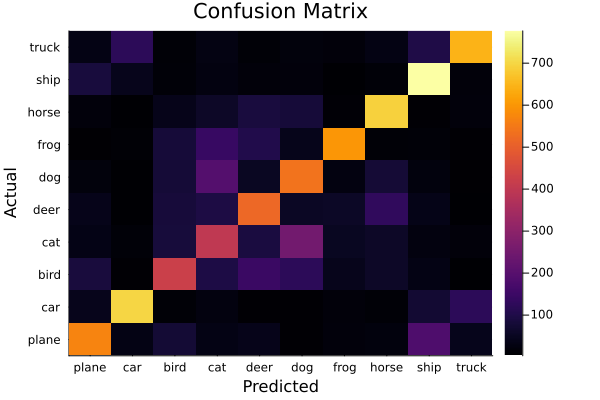

In [27]:
using StatsBase, Plots

cm = zeros(Int, 10, 10)
for (t,p) in zip(trues, preds)
    cm[t+1, p+1] += 1
end

heatmap(
  cm,
  xticks=(1:10, classes),
  yticks=(1:10, classes),
  xlabel="Predicted",
  ylabel="Actual",
  title="Confusion Matrix",
  right_margin = 10Plots.mm,
)


In [34]:
using Flux
using Flux: Conv, BatchNorm, MaxPool, flatten, Dense, Dropout, relu, softmax, Chain

# -- definicja jednego Res-bloku o stałej liczbie kanałów --
struct ResBlock
  f::Chain
end

function ResBlock(channels::Integer)
  return ResBlock(Chain(
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels), relu,
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels)
  ))
end

# aplikacja bloku: F(x)+x, potem ReLU
(m::ResBlock)(x) = relu(m.f(x) .+ x)


# -- model --
model_resNet = Chain(
  # Block 1: 3→32
  Conv((3,3), 3=>32, pad=1), BatchNorm(32), relu,
  ResBlock(32),
  MaxPool((2,2)),      # 32×32 → 16×16

  # Block 2: 32→64
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  ResBlock(64),
  MaxPool((2,2)),      # 16×16 → 8×8

  # Flatten i head
  flatten,             # 64*8*8 = 4096
  Dense(4096, 128),    BatchNorm(128), relu, Dropout(0.5),
  Dense(128, 10),
  softmax
) |> device


Chain(
  Conv((3, 3), 3 => 32, pad=1),         # 896 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
      NNlib.relu,
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
    ),
  ),
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
      NNlib.relu,
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
    ),
  ),
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 128),                   # 524_416 para

In [35]:
model_resNet(train_set[1][1])

10×64 Matrix{Float32}:
 0.0972511  0.0963427  0.100936   …  0.0950108  0.0924727  0.10499
 0.0882251  0.0813445  0.0762757     0.0801272  0.0781013  0.0847829
 0.0964296  0.0969014  0.101511      0.0980928  0.10379    0.102431
 0.12726    0.117714   0.113205      0.126013   0.115628   0.115045
 0.0781065  0.067284   0.0599122     0.0664239  0.0667426  0.0753181
 0.0878694  0.0942138  0.0973453  …  0.0917658  0.0896486  0.0926527
 0.119802   0.136409   0.142168      0.131371   0.13474    0.121488
 0.10105    0.109336   0.0993534     0.101367   0.104661   0.0969971
 0.103362   0.103646   0.115159      0.113855   0.114357   0.10871
 0.100643   0.0968084  0.0941343     0.0959741  0.0998581  0.0975856

In [47]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model_resNet);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [53]:
function accuracy_batched(model, X, Y; batchsize=64)
  total, correct = 0, 0
  N = size(X, 4)
  for i in 1:batchsize:N
    j = min(i+batchsize-1, N)
    xb = device(X[:,:,:, i:j])
    yb = device(Y[:,   i:j])
    ŷ = model(xb)
    p = Flux.onecold(ŷ, 0:9)
    t = Flux.onecold(yb, 0:9)
    correct += sum(p .== t)
    total   += length(t)
  end
  return correct / total
end

acc = accuracy_batched(model, X_test, Y_test; batchsize=batch_size)
@info("Test accuracy: $(round(acc*100, digits=2))%")

┌ Info: Test accuracy: 10.87%
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\DeepLearningProjektZaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X65sZmlsZQ==.jl:18


In [ ]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model_resNet, train_set, opt_state)
    acc = accuracy_batched(model_resNet, X_test, Y_test; batchsize=batch_size)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to model_resNet.bson")
        ps = cpu(Flux.state(model_resNet))
        BSON.@save "model_resNet.bson" ps
        jldsave("model_resNet.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

In [ ]:
model_resNet = Chain(
  # Block 1: 3→32
  Conv((3,3), 3=>32, pad=1), BatchNorm(32), relu,
  ResBlock(32),
  MaxPool((2,2)),      # 32×32 → 16×16

  # Block 2: 32→64
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  ResBlock(64),
  MaxPool((2,2)),      # 16×16 → 8×8

  # Flatten i head
  flatten,             # 64*8*8 = 4096
  Dense(4096, 128),    BatchNorm(128), relu, Dropout(0.5),
  Dense(128, 10),
  softmax
) |> device

BSON.@load "model_resNet.bson" ps

Flux.loadmodel!(model_resNet, device(ps))

In [ ]:
accuracy(model_resNet,test_set[1],test_set[2])

In [39]:
using Flux
using Flux: Conv, BatchNorm, MaxPool, flatten, Dense, Dropout, relu, softmax, Chain

# VGG-like CNN dla wejścia 3×32×32
model_vgg = Chain(
  # --- blok 1: 3 → 64 ---
  Conv((3,3), 3=>64, pad=1), relu,
  Conv((3,3), 64=>64, pad=1), relu,
  MaxPool((2,2)),               # 32×32 → 16×16

  # --- blok 2: 64 → 128 ---
  Conv((3,3), 64=>128, pad=1), relu,
  Conv((3,3), 128=>128, pad=1), relu,
  MaxPool((2,2)),               # 16×16 → 8×8

  # --- blok 3: 128 → 256 ---
  Conv((3,3), 128=>256, pad=1), relu,
  Conv((3,3), 256=>256, pad=1), relu,
  MaxPool((2,2)),               # 8×8 → 4×4

  # spłaszczamy
  flatten,                      # 256×4×4 = 4096

  # --- klasyfikator ---
  Dense(4096, 512), relu, Dropout(0.5),
  Dense(512, 256), relu, Dropout(0.5),
  Dense(256, 10),
  softmax
) |> device


Chain(
  Conv((3, 3), 3 => 64, pad=1),         # 1_792 parameters
  NNlib.relu,
  Conv((3, 3), 64 => 64, pad=1),        # 36_928 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, pad=1),       # 73_856 parameters
  NNlib.relu,
  Conv((3, 3), 128 => 128, pad=1),      # 147_584 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, pad=1),      # 295_168 parameters
  NNlib.relu,
  Conv((3, 3), 256 => 256, pad=1),      # 590_080 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 512),                   # 2_097_664 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(512 => 256),                    # 131_328 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(256 => 10),                     # 2_570 parameters
  NNlib.softmax,
)                   # Total: 18 arrays, 3_376_970 parameters, 12.884 MiB.

In [40]:
model_vgg(train_set[1][1])

10×64 Matrix{Float32}:
 0.100961   0.101944   0.101301   …  0.101302   0.101147   0.101232
 0.102733   0.10367    0.102978      0.102827   0.102651   0.102368
 0.100931   0.10137    0.101351      0.100633   0.100751   0.100732
 0.101492   0.101382   0.101066      0.102418   0.101033   0.100284
 0.101086   0.100827   0.100496      0.100528   0.100429   0.100695
 0.100788   0.10114    0.100992   …  0.100987   0.100971   0.100222
 0.0987645  0.0987983  0.0988188     0.0990776  0.0989555  0.0993677
 0.0973861  0.0961443  0.0961557     0.0973677  0.0976316  0.0976456
 0.0977864  0.0977268  0.0981418     0.0974434  0.0987833  0.098769
 0.0980713  0.096996   0.0987001     0.0974148  0.0976473  0.098685

In [41]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model_vgg);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [42]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model_vgg, train_set, opt_state)
    acc = accuracy(model_vgg,test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to model_vgg.bson")
        ps = cpu(Flux.state(model_vgg))
        BSON.@save "model_vgg.bson" ps
        jldsave("model_vgg.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\DeepLearningProjektZaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X62sZmlsZQ==.jl:1


OutOfMemoryError: OutOfMemoryError()

In [ ]:
model_vgg = Chain(
  # --- blok 1: 3 → 64 ---
  Conv((3,3), 3=>64, pad=1), relu,
  Conv((3,3), 64=>64, pad=1), relu,
  MaxPool((2,2)),               # 32×32 → 16×16

  # --- blok 2: 64 → 128 ---
  Conv((3,3), 64=>128, pad=1), relu,
  Conv((3,3), 128=>128, pad=1), relu,
  MaxPool((2,2)),               # 16×16 → 8×8

  # --- blok 3: 128 → 256 ---
  Conv((3,3), 128=>256, pad=1), relu,
  Conv((3,3), 256=>256, pad=1), relu,
  MaxPool((2,2)),               # 8×8 → 4×4

  # spłaszczamy
  flatten,                      # 256×4×4 = 4096

  # --- klasyfikator ---
  Dense(4096, 512), relu, Dropout(0.5),
  Dense(512, 256), relu, Dropout(0.5),
  Dense(256, 10),
  softmax
) |> device

BSON.@load "model_vgg.bson" ps

Flux.loadmodel!(model_vgg, device(ps))